### import packages

In [28]:
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, project, TransferManager
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle as pkl


# %matplotlib widget

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

### Constants

In [29]:
# Constants
spy = 365.25 * 24 * 60 * 60
ρ = Constant(917.0)    # kg / m^3
c = Constant(2180)     # J / kg C
k = Constant(2.22)  # W / m C
α = (k/(ρ*c)) # diffusivity
A = 3.5e-25 
n = 3
R = 8.31446261815324
act_vol = -1.74e-5
Q = 6e4 # activatyion energy J/mol

dTdz = 2e-2 #C per 100m
geo_flux = Constant(46e-3) #W/m^2

λ = Constant(10.0)    # m
grav = Constant(-9.81) #m/s^2

vel_mpy = Constant(0.50) #m/yr
vel = vel_mpy / spy

# Surface condition
T_mean = -31 #average temp (C)
T_surface = Constant(T_mean) #

def ε(u):
    return sym(grad(u))

### Create the initial mesh

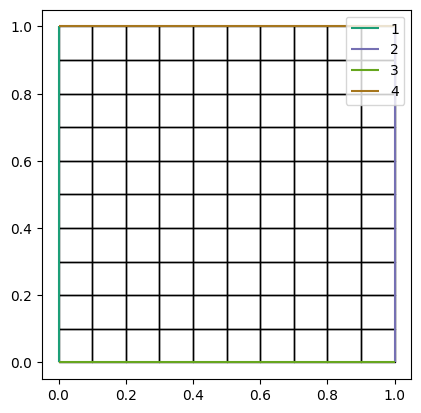

In [30]:
#Creating the initial mesh dimensions

nx, nz = 10, 10
initial_mesh = firedrake.UnitSquareMesh(nx, nz, quadrilateral=True)

fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(initial_mesh, axes=ax)
ax.legend();

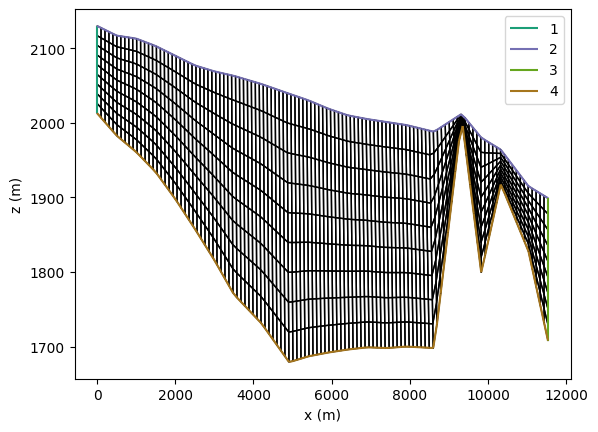

In [31]:
x, z = firedrake.SpatialCoordinate(initial_mesh)
mesh_full = Mesh('Current_meshes/ALHIC1902_full_flowline_scaled_lowres.msh')
# Input the mesh dimensions here, not sure how to do this automatically
right_boundary_heights = []

for i in mesh_full.coordinates.dat.data:
    if i[0] == np.max(mesh_full.coordinates.dat.data[:,0]):
        right_boundary_heights.append(i[1])

depth = np.max(right_boundary_heights) - np.min(right_boundary_heights)

# length = 24000

# slope = (height_max - height_min) / length


x_full, z_full = firedrake.SpatialCoordinate(mesh_full)

bed_id = [4]
left_id = [1]
surface_id = [2]
right_id = [3]

fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
firedrake.triplot(mesh_full, axes=ax)
# ax.set_ylim([-100,100])
# ax.set_xlim([0,500])
ax.set_aspect("auto")
ax.legend();

### Build the temperature, pressure, and velocity space

In [32]:
element = firedrake.FiniteElement("CG", "quadrilateral", 1)
V_full = firedrake.FunctionSpace(mesh_full, element)

T_full = firedrake.Function(V_full)
ϕ_full = firedrake.TestFunction(V_full)

In [33]:
pressure_space_full = firedrake.FunctionSpace(mesh_full, "CG", 1)
velocity_space_full = firedrake.VectorFunctionSpace(mesh_full, "CG", 2)
Y_full = velocity_space_full * pressure_space_full

y_full = firedrake.Function(Y_full)
u_full, p_full = firedrake.split(y_full)


μ = Constant(5e15) #Ice
# μ = Constant(1e14) #Test


v_full, q_full = firedrake.TestFunctions(y_full.function_space())

τ_full = 2 * μ * ε(u_full)
g = as_vector((0, grav))
f =  ρ * g

F_momentum_full = (inner(τ_full, ε(v_full)) - q_full * div(u_full) - p_full * div(v_full) - inner(f, v_full)) * dx

### Define the boundary conditions

#### Surface temp follows the dry abiatic lapse rate

In [34]:
temperature_expr_full = T_mean - (z_full - 2000)*.01

#### veclocity boundary conditions:
#### - linear ramp accum tp zero at the bed at the dome
#### - zero at the bed
#### - linear ramp zero to ablation at the surface

In [35]:
## Downward velocity at the divide, we will say is linear ##

w_s_divide = -0.05 / spy

divide_heights = []
for i in mesh_full.coordinates.dat.data:
    if i[0] == 0:
        divide_heights.append(i[1])

divide_depth = np.max(divide_heights) - np.min(divide_heights)

w_divide = w_s_divide * (((z_full - np.min(divide_heights)) / divide_depth))

In [36]:
## Downward velocity at the divide, we will say is linear ##

w_s_abl = 0.02 / spy

abl_boundary_heights_full = []

for i in mesh_full.coordinates.dat.data:
    if i[0] == np.max(mesh_full.coordinates.dat.data[:,0]):
        abl_boundary_heights_full.append(i[1])


abl_depth_full = np.max(abl_boundary_heights_full) - np.min(abl_boundary_heights_full)

w_abl_full = w_s_abl * (((z_full - np.min(abl_boundary_heights_full)) / abl_depth_full))

In [37]:

bc_l_full = firedrake.DirichletBC(Y_full.sub(0), as_vector((0, w_divide)), left_id)
bc_r = firedrake.DirichletBC(Y_full.sub(0), as_vector((0, w_abl_full)), right_id)
bc_b = firedrake.DirichletBC(Y_full.sub(0), as_vector((0, 0)), bed_id) 

bc_stokes_full=[bc_l_full, bc_b, bc_r]
#bc_stokes=[bc_l, bc_r]
# bc_temp = [top_temp_bc]

#### Full stokes solve

In [38]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace_full = firedrake.MixedVectorSpaceBasis(Y_full, [Y_full.sub(0), basis])

stokes_problem_full = firedrake.NonlinearVariationalProblem(F_momentum_full, y_full, bc_stokes_full)
parameters = {
    "nullspace": nullspace_full,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
stokes_solver_full = firedrake.NonlinearVariationalSolver(stokes_problem_full, **parameters)

stokes_solver_full.solve()

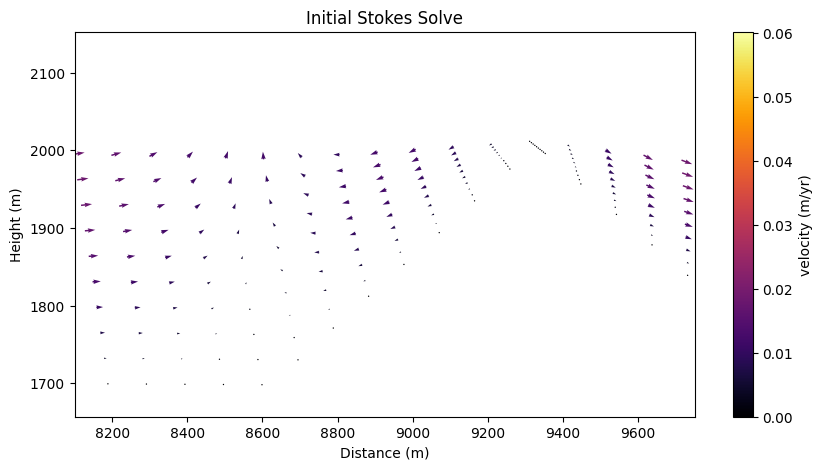

In [39]:
fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot_full = firedrake.quiver(y_full.sub(0)*spy, axes=axes, cmap="inferno", scale=1);
fig.colorbar(vel_field_plot_full, label='velocity (m/yr)')
axes.set_ylabel('Height (m)')
axes.set_xlabel('Distance (m)')
axes.set_title('Initial Stokes Solve')
axes.set_xlim([8100,9750])
# axes.set_ylim([1700,1800])
plt.show()
# fig.savefig('Test_model_flowfield.png')

#### Steady state temperature

In [40]:
geothermal_flux = -geo_flux*ϕ_full  * ds((bed_id[0]))

# F = k * inner(grad(T_full), grad(ϕ_full)) * dx + geothermal_flux

# # surf_bc = firedrake.DirichletBC(V, T_surface, surf_ids)
# #surf_bc = firedrake.DirichletBC(V, T_surface+(slope / (1/100))*(1 + (x/length)), surface_id) #slope / (1/100) term is the dry adiabat following the slope
# top_temp_bc = firedrake.DirichletBC(V_full, temperature_expr_full, surface_id)
# bcs = [top_temp_bc]

# firedrake.solve(F == 0, T_full, bcs)

In [41]:
geothermal_flux = -geo_flux*ϕ_full  * ds((bed_id[0]))

F_diffusion = k * inner(grad(T_full), grad(ϕ_full)) * dx
F_advection = - ρ * c * T_full * inner(u_full, grad(ϕ_full)) * dx

F_0 = F_advection + F_diffusion + geothermal_flux

top_temp_bc = firedrake.DirichletBC(V_full, temperature_expr_full, surface_id)
bcs = [top_temp_bc]
firedrake.solve(F_0 == 0, T_full, bcs)

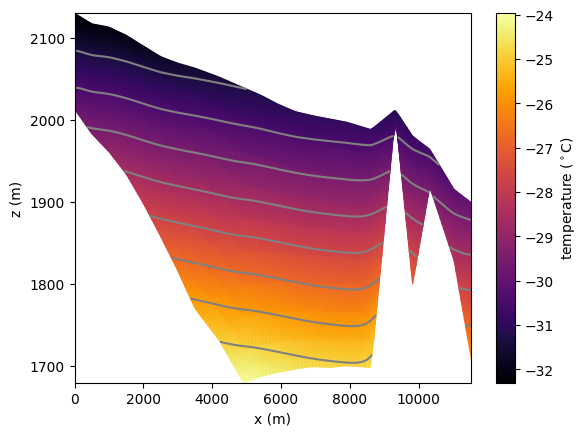

In [42]:
fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(T_full, cmap="inferno", axes=ax)
fig.colorbar(colors, label="temperature (${}^\circ$C)")
levels = np.linspace(T_full.dat.data.min(), T_full.dat.data.max(), 10)
firedrake.tricontour(T_full, levels=levels, colors="grey", axes=ax);
# ax.set_xlim([9000,10000]);

## Time dependent piece here

In [61]:
import irksome
from irksome import Dt

δx = mesh_full.cell_sizes.dat.data_ro[:].min()
umax = y_full.sub(0).dat.data_ro[:].max()
δt = Constant(100*spy)

geothermal_flux = -geo_flux*ϕ_full  * ds((bed_id[0]))
F_diffusion = k * inner(grad(T_full), grad(ϕ_full)) * dx
F_advection = - ρ * c * T_full * inner(u_full, grad(ϕ_full)) * dx

F = ρ * c * Dt(T_full) * ϕ_full * dx + F_advection + F_diffusion + geothermal_flux 


temperature_expr_full = T_mean - (z_full - 2000)*.01
top_temp_bc = firedrake.DirichletBC(V_full, temperature_expr_full, surface_id)
bcs = [top_temp_bc]


method = irksome.BackwardEuler()
temperature_solver = irksome.TimeStepper(F, method, Constant(0.0), δt, T_full, bcs=bcs)

### Surface temp to model

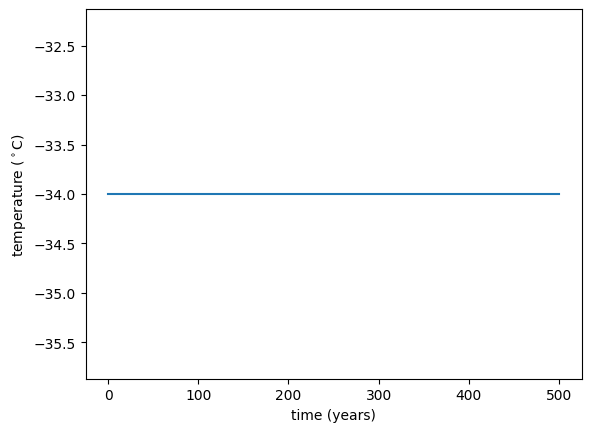

In [62]:
δT = 25.0
θ = 1 * π / 2
year = spy
years = 500
final_time = years * spy # years modeling * spy

freq = 1 # 1 for annual cycle
num_steps = int(final_time / float(δt))
T_mean_test = -34
mag_warming = 0
# def surface_temperature(t):
#     return T_mean + δT * np.sin(2 * π *freq* t / year + θ) + (t/final_time)*1

def surface_temperature(t):
    return T_mean_test  + (t/final_time)*mag_warming
    
ts = np.linspace(0.0, final_time, num_steps + 1)

surface_temps = surface_temperature(ts)

fig, ax = plt.subplots()
ax.set_xlabel("time (years)")
ax.set_ylabel("temperature (${}^\circ$C)")
ax.plot(ts / spy, surface_temps);

In [63]:
import tqdm
final_time = years* spy 
num_steps = int(final_time / float(δt))
Ts = [T_full.copy(deepcopy=True)]
ys = [y_full.copy(deepcopy=True)]

for step in tqdm.trange(num_steps):
    t = ts[step]
    T_surface.assign(surface_temperature(t))

    temperature_solver.advance()
    stokes_solver.solve()

    Ts.append(T_full.copy(deepcopy=True))
    ys.append(y_full.copy(deepcopy=True))

  0%|                                                                                 | 0/5 [00:00<?, ?it/s]


ConvergenceError: Nonlinear solve failed to converge after 50 nonlinear iterations.
Reason:
   DIVERGED_MAX_IT